In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import datasets, image, input_data
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

### CC200 Atlas Demonstration

In [12]:
cc200_img = nib.load('s3bucket_shortcut/data/Projects/ABIDE/Resources/cc200_roi_atlas.nii.gz')
cc200_data = cc200_img.get_fdata()
print(cc200_data.shape)

(63, 75, 61)


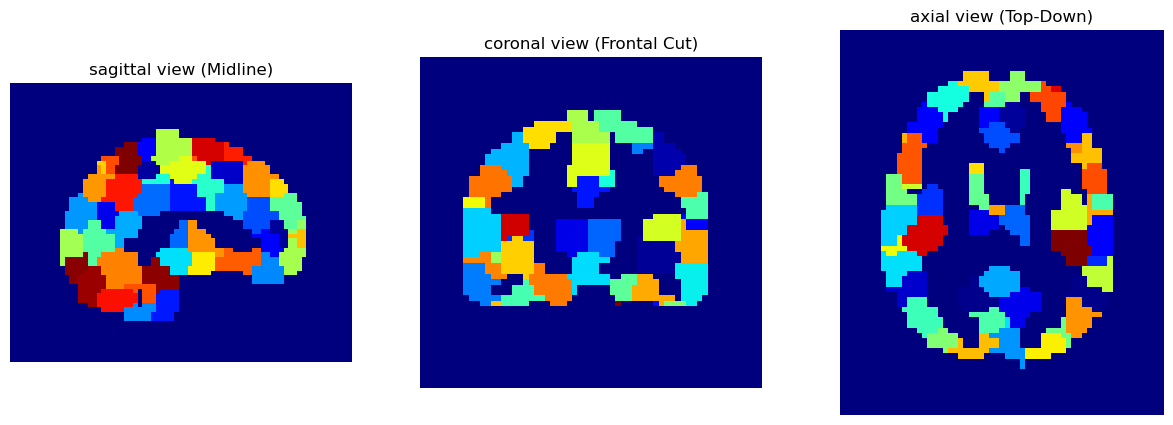

In [13]:
sagittal_slice = cc200_data[cc200_data.shape[0] // 2, :, :]
coronal_slice = cc200_data[:, cc200_data.shape[1] // 2, :]
axial_slice = cc200_data[:, :, cc200_data.shape[2] // 2]

# plotting the central slice for all three views
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.rot90(sagittal_slice), cmap="jet")
axes[0].set_title("sagittal view (Midline)")
axes[0].axis("off")

axes[1].imshow(np.rot90(coronal_slice), cmap="jet")
axes[1].set_title("coronal view (Frontal Cut)")
axes[1].axis("off")

axes[2].imshow(np.rot90(axial_slice), cmap="jet")
axes[2].set_title("axial view (Top-Down)")
axes[2].axis("off")

plt.show()


### Connectivity Matrices Examples

In [3]:
#using cpac-filt_noglobal

parent_dir = 's3bucket_shortcut/data/Projects/ABIDE/Outputs/cpac/filt_noglobal'

asd_test_path = os.path.join(parent_dir,'rois_cc200/UM_1_0050320_rois_cc200.1D')
tc_test_path = os.path.join(parent_dir,'rois_cc200/UM_1_0050341_rois_cc200.1D')

In [4]:
#to plot connectivity among ROIs

asd = np.loadtxt(asd_test_path)   #file path to fmri scan
tc = np.loadtxt(tc_test_path)


In [6]:
print(tc.shape)

(296, 200)


In [7]:
roi_asd = asd.T
roi_tc = tc.T
# pearson correlation
asd_fc = np.corrcoef(roi_asd)  # shape: (200, 200)
tc_fc = np.corrcoef(roi_tc)  # shape: (200, 200)

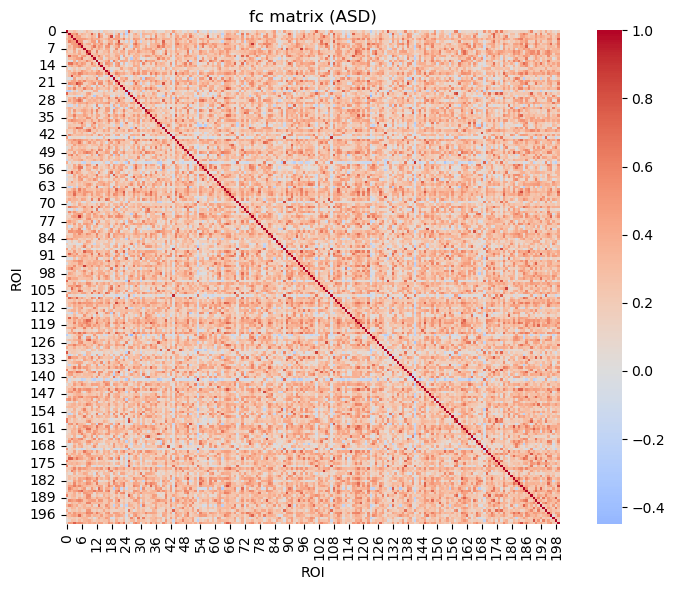

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(asd_fc, cmap='coolwarm', center=0, square=True)
plt.title('fc matrix (ASD)')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()


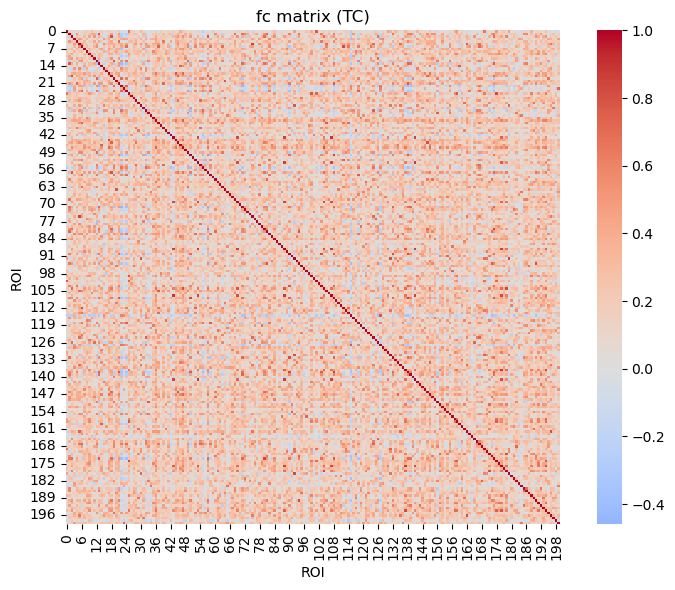

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(tc_fc, cmap='coolwarm', center=0, square=True)
plt.title('fc matrix (TC)')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()


### Phenotypic features selection tests

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('s3bucket_shortcut/data/Projects/ABIDE/Phenotypic_V1_0b_preprocessed.csv')

df['DX_GROUP'] = df['DX_GROUP'].map({1: 1, 2: 0})  # 1 = asd, 0 = control

In [16]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# as we are not considering the label column
if 'DX_GROUP' in num_cols:
    num_cols.remove('DX_GROUP')


In [17]:
#viq, piq, func_quality, func_mean_fd, func_num_fd,  func_perc_fd, func_gsr

from scipy.stats import ttest_ind

for col in ['VIQ', 'PIQ', 'func_quality', 'func_mean_fd', 'func_num_fd', 'func_perc_fd']:
    asd_vals = df[df['DX_GROUP'] == 1][col].dropna()
    ctrl_vals = df[df['DX_GROUP'] == 0][col].dropna()

    # removing placeholder (-9999) and NaN (already removed above)
    asd_vals = asd_vals[asd_vals > -1000]
    ctrl_vals = ctrl_vals[ctrl_vals > -1000]

    stat, p = ttest_ind(asd_vals, ctrl_vals)
    print(f"{col:20} | p-value: {p:.15f}")


VIQ                  | p-value: 0.000000000001343
PIQ                  | p-value: 0.003308655518893
func_quality         | p-value: 0.000000438188166
func_mean_fd         | p-value: 0.000000000328360
func_num_fd          | p-value: 0.000000004601819
func_perc_fd         | p-value: 0.000000000248086


In [ ]:
def cohens_d(a, b):
    return (a.mean() - b.mean()) / (((a.std() ** 2 + b.std() ** 2) / 2) ** 0.5)

#this will tell us the size -> a larger (pos/neg) cohens_d means the difference in ASD/control is larger
for col in ['VIQ', 'PIQ', 'func_quality', 'func_mean_fd', 'func_num_fd', 'func_perc_fd']:
    asd_vals = df[df['DX_GROUP'] == 1][col].dropna()
    ctrl_vals = df[df['DX_GROUP'] == 0][col].dropna()
    asd_vals = asd_vals[asd_vals > -1000]
    ctrl_vals = ctrl_vals[ctrl_vals > -1000]

    d = cohens_d(asd_vals, ctrl_vals)
    print(f"{col:20} | Cohen's d: {d:.3f}")


VIQ                  | Cohen's d: -0.475
PIQ                  | Cohen's d: -0.193
func_quality         | Cohen's d: 0.304
func_mean_fd         | Cohen's d: 0.379
func_num_fd          | Cohen's d: 0.355
func_perc_fd         | Cohen's d: 0.384


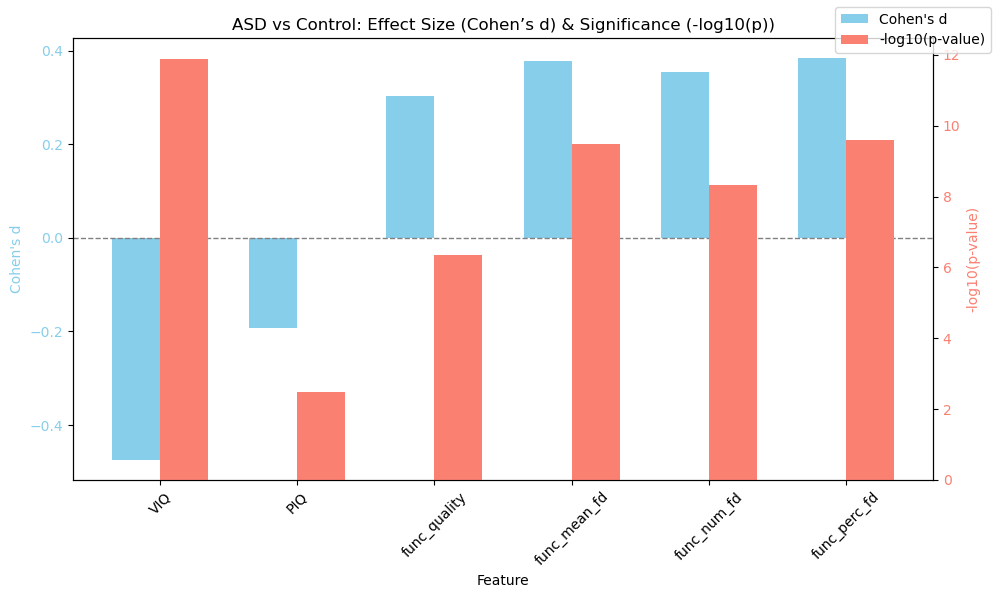

In [20]:
from scipy.stats import ttest_ind

features = ['VIQ', 'PIQ', 'func_quality', 'func_mean_fd', 'func_num_fd', 'func_perc_fd']
cohens_d_vals = []
p_vals = []

for col in features:
    asd_vals = df[df['DX_GROUP'] == 1][col].dropna()
    ctrl_vals = df[df['DX_GROUP'] == 0][col].dropna()

    # placeholders must be removed, like -9999, etc
    asd_vals = asd_vals[asd_vals > -1000]
    ctrl_vals = ctrl_vals[ctrl_vals > -1000]

    # t-test
    stat, p = ttest_ind(asd_vals, ctrl_vals)
    p_vals.append(p)


    d = cohens_d(asd_vals, ctrl_vals)
    cohens_d_vals.append(d)

# scale p to -log10, for plotting
neg_log_p_vals = [-np.log10(p) if p > 0 else 0 for p in p_vals]

# plot
x = np.arange(len(features))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

bar1 = ax1.bar(x - width/2, cohens_d_vals, width, label="Cohen's d", color='skyblue')
ax1.set_ylabel("Cohen's d", color='skyblue')
ax1.set_xlabel("Feature")
ax1.set_xticks(x)
ax1.set_xticklabels(features, rotation=45)
ax1.axhline(0, linestyle='--', color='gray', linewidth=1)
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, neg_log_p_vals, width, label='-log10(p-value)', color='salmon')
ax2.set_ylabel("-log10(p-value)", color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Title and legend
plt.title("ASD vs Control: Effect Size (Cohen’s d) & Significance (-log10(p))")
fig.tight_layout()
fig.legend(loc='upper right')

plt.show()
